In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks
import numpy as np
import music21
import glob

from src.utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

In [38]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "data/parsed_sequences"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

In [39]:
file_list = glob.glob("data/raw/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [40]:
parser = music21.converter
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [41]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x143f22090>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark adagio Quarter=55>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord C2 C3>
    {1.0} <music21.chord.Chord C3>
    {1.25} <music21.chord.Chord G2>
    {1.5} <music21.chord.Chord A2>
    {1.75} <music21.chord.Chord B2>
    {2.0} <music21.chord.Chord C3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E-3>
    {2.75} <music21.chord.Chord F3>
    {3.0} <music21.chord.Chord E-3>
    {3.25} <music21.chord.Chord D3>
    {3.5} <music21.chord.Chord E-3>
    {3.75} <music21.chord.Chord C3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord C2 B2 F3 G#3>
    {1.5} <music21.chord.Chord G#3>
    {2.

In [42]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files(PARSED_DATA_PATH)
len(notes),len(durations)

1 Parsing data/raw/cs1-2all.mid
921 notes parsed
2 Parsing data/raw/cs5-1pre.mid
2230 notes parsed
3 Parsing data/raw/cs4-1pre.mid
3047 notes parsed
4 Parsing data/raw/cs3-5bou.mid
3928 notes parsed
5 Parsing data/raw/cs1-4sar.mid
4191 notes parsed
6 Parsing data/raw/cs2-5men.mid
4718 notes parsed
7 Parsing data/raw/cs3-3cou.mid
5707 notes parsed
8 Parsing data/raw/cs2-3cou.mid
6448 notes parsed
9 Parsing data/raw/cs1-6gig.mid
6874 notes parsed
10 Parsing data/raw/cs6-4sar.mid
7209 notes parsed
11 Parsing data/raw/cs4-5bou.mid
8533 notes parsed
12 Parsing data/raw/cs4-3cou.mid
9455 notes parsed
13 Parsing data/raw/cs5-3cou.mid
9885 notes parsed
14 Parsing data/raw/cs6-5gav.mid
10691 notes parsed
15 Parsing data/raw/cs6-6gig.mid
11863 notes parsed
16 Parsing data/raw/cs6-2all.mid
12548 notes parsed
17 Parsing data/raw/cs2-1pre.mid
13186 notes parsed
18 Parsing data/raw/cs3-1pre.mid
14167 notes parsed
19 Parsing data/raw/cs3-6gig.mid
15128 notes parsed
20 Parsing data/raw/cs2-6gig.mid
15

(27581, 27581)

In [43]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 B3 C4 G3 E3 D3 C3 E3 A3 C4 F#3 A3 C4 E4 D4 C3 B2 G3 A2 G2 D2 A2 G3 F#3 G3 G2 B2 D3 G3 B3 D4 F#4 G4 D4 B3 G3 G2 A3 A3 F#3 G3 A3 D3 E3 F#3 G3 A3 F#3 D3 C3 B2 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 1.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


In [44]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
);

In [45]:
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
         9         2
         6         2
         2         2
         8         2
         4         2
        13         2
         8         2
         3         2
         6         2
        12         2


In [46]:
print(f" tokenized notes shape: {example_tokenised_notes.shape}")
print(f" tokenized durations shape: {example_tokenised_durations.shape}")

 tokenized notes shape: (51,)
 tokenized durations shape: (51,)


In [47]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3
10: E-3
11: B-3
12: F#3
13: C3
14: G#3
15: E4
16: G2
17: C#4
18: B2
19: A2
20: B-2
21: F#4
22: G4
23: E-4
24: A4
25: C#3
26: G#2
27: F2
28: B4
29: F4
30: D2
31: E2
32: E-2
33: rest
34: C2
35: F#2
36: G#4
37: START
38: D5
39: C#5
40: 3/4TS
41: E5
42: 4/4TS
43: E-:major
44: C#2
45: B-4
46: F:major
47: C5
48: F#5
49: D:major
50: C:major
51: G:major
52: G5
53: 3/8TS
54: 6/8TS
55: 3/2TS
56: 12/8TS
57: E-5
58: B-:major

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0
10: 1/6
11: 2.0
12: 3.0
13: 1.25
14: 2.5
15: 4/3
16: 4.0
17: 2/3
18: 3.75
19: 5.5
20: 3.5
21: 3.25
22: 2.75
23: 1.75


In [48]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2025-01-05 21:03:44.840499: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [49]:
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [50]:
example_x, example_y = ds.take(1).get_single_element()
example_x[0].shape, example_x[1].shape, example_y[0].shape, example_y[1].shape

(TensorShape([256, 50]),
 TensorShape([256, 50]),
 TensorShape([256, 50]),
 TensorShape([256, 50]))

In [51]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [52]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [53]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [54]:
example_tokenised_notes.shape

TensorShape([51])

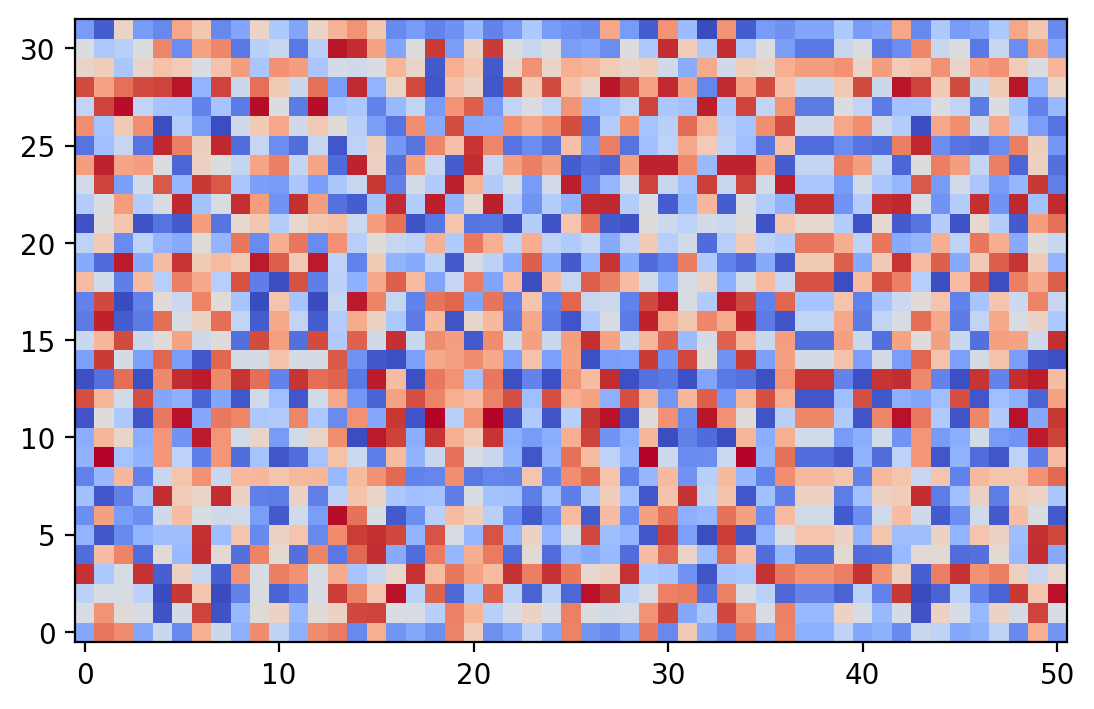

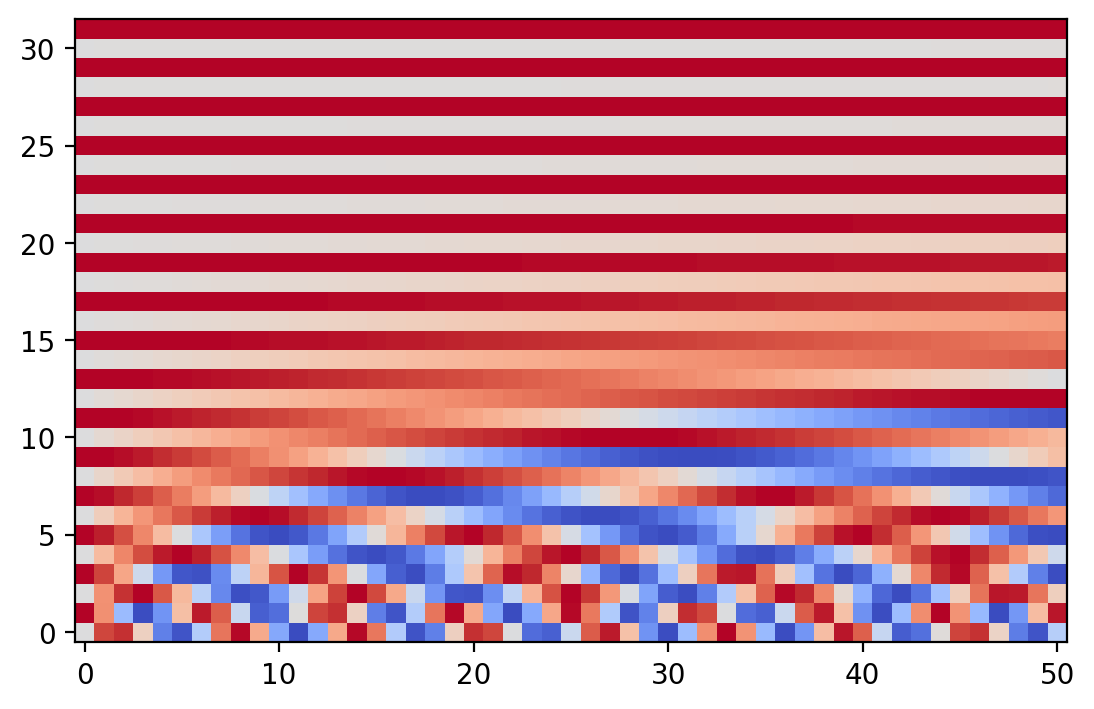

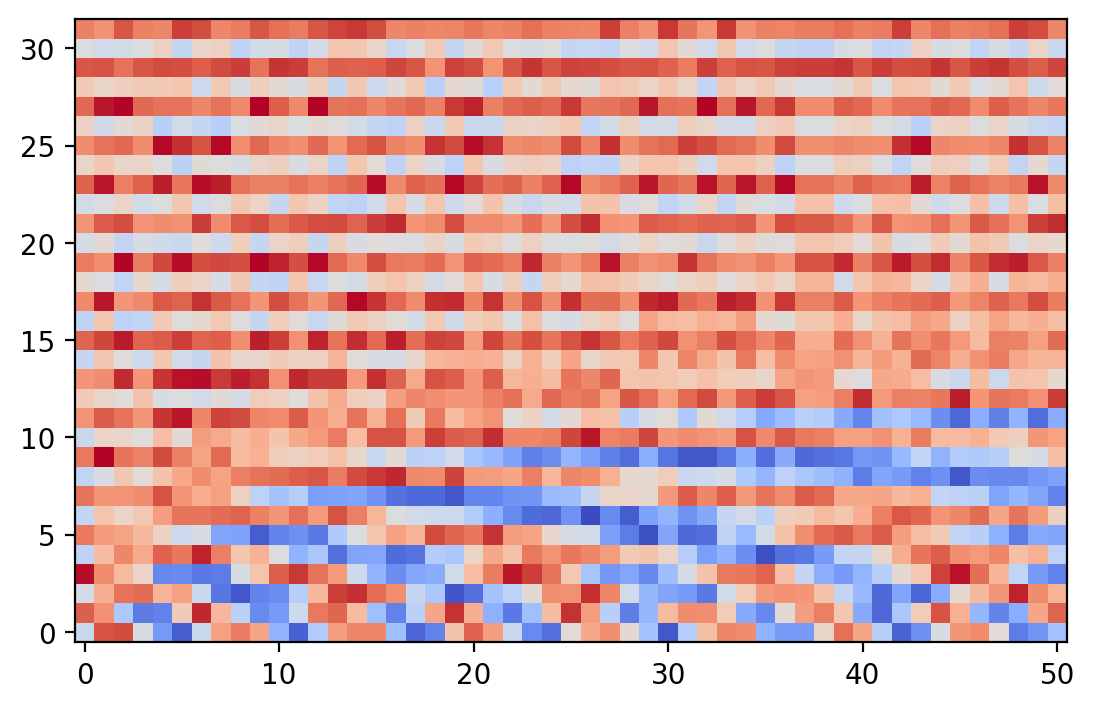

In [55]:
import matplotlib.pyplot as plt

tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [56]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)


model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)

att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [57]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      7,552 │ input_layer_2[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      3,072 │ input_layer_3[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate_1[0]… │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 59)  │     15,163 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 24)  │      6,168 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./model.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)


# Tokenize starting prompt


In [59]:
model.fit(
    ds,
    epochs=EPOCHS,
)

Epoch 1/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 64s 582ms/step - duration_outputs_loss: 1.2353 - loss: 4.8369 - note_outputs_loss: 3.6015
Epoch 2/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 63s 590ms/step - duration_outputs_loss: 0.6320 - loss: 3.4289 - note_outputs_loss: 2.7970
Epoch 3/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 65s 606ms/step - duration_outputs_loss: 0.7091 - loss: 3.3505 - note_outputs_loss: 2.6414
Epoch 4/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 62s 580ms/step - duration_outputs_loss: 0.6249 - loss: 3.1236 - note_outputs_loss: 2.4987
Epoch 5/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 63s 588ms/step - duration_outputs_loss: 0.6048 - loss: 3.0098 - note_outputs_loss: 2.4049
Epoch 6/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 62s 583ms/step - duration_outputs_loss: 0.5690 - loss: 2.9100 - note_outputs_loss: 2.3410
Epoch 7/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 62s 580ms/step - duration_outputs_loss: 0.5535 - loss: 2.8473 - note_outputs_loss: 2.2938
Epoch 8/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 64s 599ms/step - duration_outputs_


KeyboardInterrupt

